In [1]:
# Cell 1: Import và load model
import os
import numpy as np
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.models import load_model

# Load model và label encoder
model = tf.keras.models.load_model('../data/models/mel_final_model.keras')
with open('../data/models/mel_label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)


2025-05-09 16:28:24.722973: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-09 16:28:24.723669: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-09 16:28:24.727319: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-09 16:28:24.734743: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746782904.747635  238712 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746782904.75

In [2]:

# Cell 2: Hàm trích xuất đặc trưng
def extract_mel_spectrogram(audio_path, n_mels=128, n_fft=2048, hop_length=128):
    # Load audio file
    y, sr = librosa.load(audio_path, sr=None)
    
    # Extract mel spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=y, 
        sr=sr,
        n_mels=n_mels,
        n_fft=n_fft,
        hop_length=hop_length,
        fmin=20,
        fmax=sr/2,
        power=2.0
    )
    
    # Convert to log scale (dB)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # Chuẩn hóa về khoảng [0,1]
    mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
    
    # Resize về kích thước cố định (128, 32)
    mel_spec_norm = tf.image.resize(mel_spec_norm[..., np.newaxis], (128, 32))
    mel_spec_norm = mel_spec_norm.numpy()
    mel_spec_norm = mel_spec_norm[..., 0]
    
    return mel_spec_norm


In [3]:

# Cell 3: Hàm dự đoán
def predict_command(audio_path):
    # Trích xuất đặc trưng
    mel_features = extract_mel_spectrogram(audio_path)
    
    # Reshape cho model (1, 128, 32, 1)
    mel_features = mel_features.reshape(1, 128, 32, 1)
    
    # Dự đoán
    predictions = model.predict(mel_features, verbose=0)
    
    # Áp dụng softmax để có xác suất
    predictions = tf.nn.softmax(predictions)
    predictions = predictions.numpy()
    
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class]
    
    # Chuyển đổi label
    predicted_command = le.inverse_transform([predicted_class])[0]
    
    return predicted_command, confidence, mel_features, predictions[0]


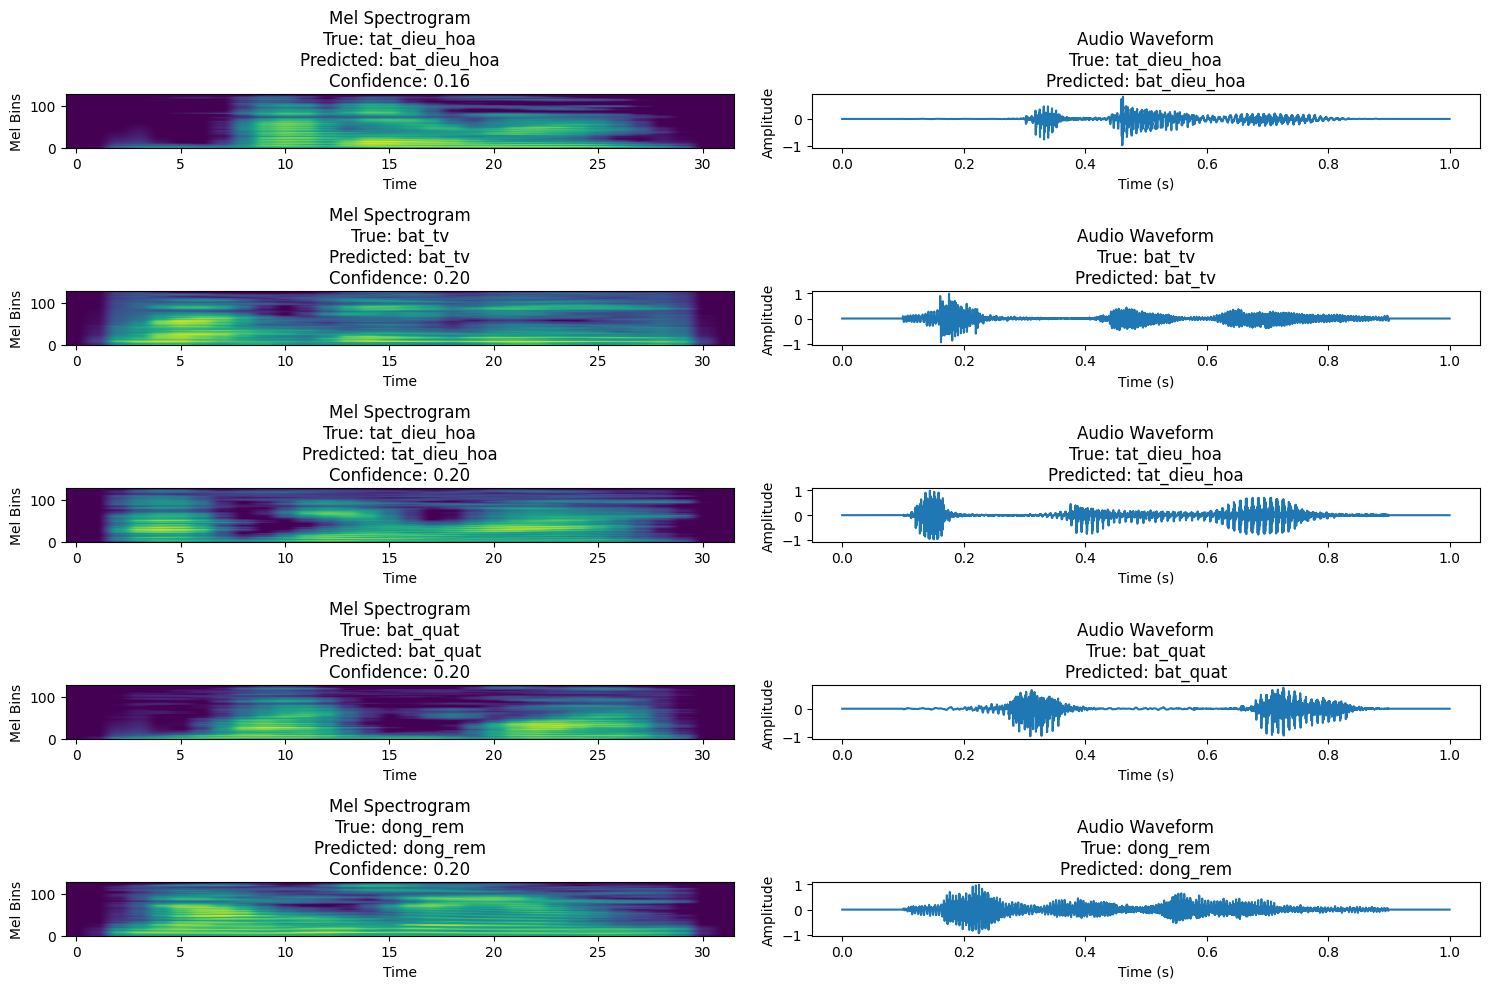

In [4]:

# Cell 4: Test với dữ liệu ngẫu nhiên
import random

# Lấy danh sách các file audio
processed_dir = '../data/processed'
audio_files = []
for root, dirs, files in os.walk(processed_dir):
    for file in files:
        if file.endswith('.wav'):
            audio_files.append(os.path.join(root, file))

# Chọn ngẫu nhiên 5 file để test
test_files = random.sample(audio_files, 5)

# test_files = ['../data/processed/bat_den/bat_den_speaker01_007.wav']

# Test và hiển thị kết quả
plt.figure(figsize=(15, 10))
for i, audio_path in enumerate(test_files):
    # Lấy label thực tế
    true_command = os.path.basename(os.path.dirname(audio_path))
    
    # Dự đoán
    predicted_command, confidence, mel_features, all_probs = predict_command(audio_path)
    
    # Hiển thị kết quả
    plt.subplot(5, 2, i*2 + 1)
    plt.imshow(mel_features[0, :, :, 0], aspect='auto', origin='lower', cmap='viridis')
    plt.title(f'Mel Spectrogram\nTrue: {true_command}\nPredicted: {predicted_command}\nConfidence: {confidence:.2f}')
    plt.xlabel('Time')
    plt.ylabel('Mel Bins')
    
    # Hiển thị waveform
    plt.subplot(5, 2, i*2 + 2)
    y, sr = librosa.load(audio_path, sr=None)
    plt.plot(np.linspace(0, len(y)/sr, len(y)), y)
    plt.title(f'Audio Waveform\nTrue: {true_command}\nPredicted: {predicted_command}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


In [5]:

# Cell 5: In kết quả chi tiết
print("\nDetailed Results:")
print("=" * 60)
for audio_path in test_files:
    true_command = os.path.basename(os.path.dirname(audio_path))
    predicted_command, confidence, _, all_probs = predict_command(audio_path)
    
    print(f"Audio file: {os.path.basename(audio_path)}")
    print(f"True label: {true_command}")
    print(f"Prediction: {predicted_command}")
    print(f"Confidence: {confidence:.2%}")
    
    print("\nProbabilities for each class:")
    # Sort probabilities in descending order
    sorted_probs = sorted(enumerate(all_probs), key=lambda x: x[1], reverse=True)
    for i, prob in sorted_probs:
        command = le.inverse_transform([i])[0]
        print(f"{command:15s}: {prob:.2%}")
    
    print(f"\nResult: {'✓ Correct' if true_command == predicted_command else '✗ Wrong'}")
    print("=" * 60)


Detailed Results:
Audio file: tat_dieu_hoa_speaker03_004.wav
True label: tat_dieu_hoa
Prediction: bat_dieu_hoa
Confidence: 16.12%

Probabilities for each class:
bat_dieu_hoa   : 16.12%
dong_rem       : 8.33%
tat_dieu_hoa   : 8.19%
tat_tv         : 7.59%
tat_quat       : 7.50%
bat_quat       : 7.49%
bat_tv         : 7.48%
do_am          : 7.46%
tat_den        : 7.46%
mo_rem         : 7.46%
bat_den        : 7.46%
nhiet_do       : 7.46%

Result: ✗ Wrong
Audio file: bat_tv_speaker02_008.wav
True label: bat_tv
Prediction: bat_tv
Confidence: 19.81%

Probabilities for each class:
bat_tv         : 19.81%
bat_den        : 7.29%
bat_dieu_hoa   : 7.29%
bat_quat       : 7.29%
do_am          : 7.29%
dong_rem       : 7.29%
mo_rem         : 7.29%
nhiet_do       : 7.29%
tat_den        : 7.29%
tat_dieu_hoa   : 7.29%
tat_quat       : 7.29%
tat_tv         : 7.29%

Result: ✓ Correct
Audio file: tat_dieu_hoa_speaker01_009.wav
True label: tat_dieu_hoa
Prediction: tat_dieu_hoa
Confidence: 19.82%

Probabilit